In [1]:
import denn.rans.channel_flow as chan
import matplotlib.pyplot as plt
import numpy as np
import denn.rans.rans_utils as utils
import pandas as pd

In [2]:
# continuously load modules (for easier debugging)
%load_ext autoreload
%autoreload 2

In [3]:
# overall hypers
pde_nn = chan.Chanflow()
hypers=pde_nn.hypers
retau=utils.calc_retau(hypers['delta'], hypers['dp_dx'], hypers['rho'], hypers['nu'])
print('Calculating at Retau={}'.format(retau))

# grid
delta=hypers['delta']
n = hypers['n']
y = np.linspace(hypers['ymin'], hypers['ymax'], n)
delta_y = y[1] - y[0]
u0 = np.ones_like(y)
U_0, U_L = 0, 0

Calculating at Retau=180.0000018


In [4]:
hypers

{'dp_dx': -1.0,
 'nu': 0.0055555555,
 'rho': 1.0,
 'k': 0.41,
 'num_units': 40,
 'num_layers': 2,
 'batch_size': 1000,
 'lr': 0.0001,
 'num_epochs': 1000,
 'ymin': -1,
 'ymax': 1,
 'weight_decay': 0,
 'delta': 1,
 'n': 1000,
 'in_dim': 1,
 'out_dim': 1,
 'retau': 180,
 'sampling': 'grid',
 'activation': 'tanh'}

In [5]:
from scipy.integrate import solve_bvp

$$\nu \frac{d^2u}{dy^2} + \frac{d}{dy}\left[\left(\frac{\kappa}{2 \delta} \left(|y| - \delta\right)\right)^{2} \left|\frac{du}{dy}\right| \frac{du}{dy}\right] - \frac{1}{\rho} \frac{dp}{dx} = 0$$

transformed to

$$ \frac{du}{dy} = v $$

$$ \frac{dv}{dy} = \frac{-\kappa^2 \left(4 (y^2 - \delta) y \times \text{sign}\left(\frac{du}{dy}\right) \frac{du}{dy}^2 \right) + \frac{1}{\rho} \frac{dp}{dx}}{\nu + \kappa^2 \left((y^2 - \delta)^2 \times \left( \text{sign}\left(\frac{du}{dy}\right)\frac{du}{dy} + \left|\frac{du}{dy}\right| \right)\right)} $$

# New, preferred method

In [6]:
from denn.rans.numerical import solve_rans_scipy_solve_bvp

In [7]:
y = np.linspace(-1, 1, 100)

In [9]:
res = solve_rans_scipy_solve_bvp(y, max_nodes=10000)
res.message

'The algorithm converged to the desired accuracy.'

In [22]:
yplt = np.linspace(-1,1,100)

In [12]:
dns = pd.read_csv('../../data/LM_Channel_Retau180.txt', delimiter=' ')
half_u, half_y = utils.convert_dns(hypers, dns)

In [13]:
full_y = np.concatenate((half_y, -half_y + 2))
full_u = np.concatenate((half_u, half_u))

In [17]:
old_res = np.load('../../data/mixlen_numerical_u180_halfk.npy')

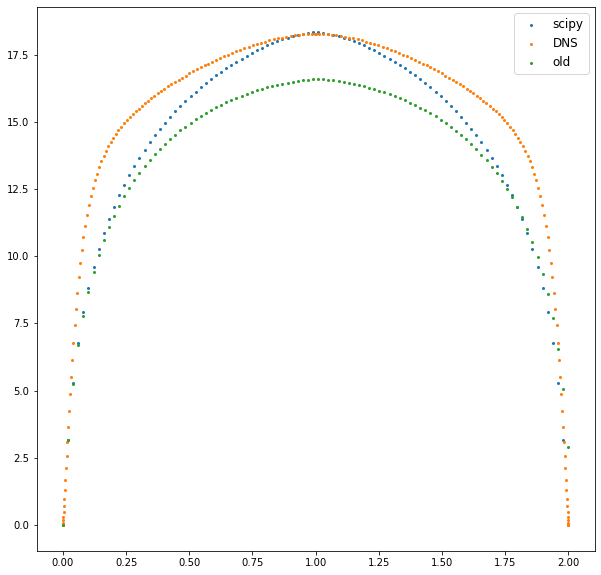

In [29]:
plt.figure(figsize=(10,10))
sol = res.sol(yplt)[0]
plt.scatter(yplt + 1, sol, s=4, alpha=1, label='scipy')
plt.scatter(full_y, full_u, s=4, label='DNS')
plt.scatter(yplt + 1, old_res[::10], s=4, label='old')
plt.legend();

# Old, below

In [10]:
rho = hypers['rho']
dpdx = hypers['dp_dx']
k = hypers['k'] / 4
nu = hypers['nu']
delta = hypers['delta']

```
y1' = y2
y2' = -exp(y1)
```

```
def func(y,x):
    return [ 
        y[1], 
        y[2], 
        ( 7*x**1.5 - 5*x**2*y[2]-2*x*y[1] + 2*y[0]) / x**3 
        ]   
```

```
u' = v
v' = (1/nu) * [-( ((k/(2*delta))**2) *  ) + (1/rho)dpdx]
```

In [6]:
def fun(y, u):
    du_sig = np.sign(u[1])
    a = 4*((y**2)-delta)*y*du_sig*u[1]**2
    b = ((y**2)-delta)**2
    return np.vstack([
        u[1],
        (-(k**2)*a + dpdx/rho)/( nu + (k**2) * b * ( du_sig * u[1] + np.abs(u[1]) ) )
    ])

In [7]:
def bc(ua, ub):
    return np.array([ua[0], ub[0]])

In [8]:
y = np.linspace(hypers['ymin'], hypers['ymax'], 100)
u0 = np.zeros((2, y.size))
u0.shape, y.shape

((2, 100), (100,))

In [9]:
res = solve_bvp(fun, bc, y, u0, max_nodes=100000, tol=1e-6)

In [10]:
res.success, res.message

(True, 'The algorithm converged to the desired accuracy.')

In [11]:
res.x.shape, res.y[0].shape

((5987,), (5987,))

# OLD (below)

In [75]:
# just here for reference.
# reynolds_stress_fn = lambda y, du_dy: -1*((hypers['k']*(np.abs(y)-delta))**2)*np.abs(du_dy)*du_dy
# diffeq = lambda du2_dy2, dre_dy: hypers['nu']*du2_dy2 - dre_dy - (1/hypers['rho']) * hypers['dp_dx']

In [230]:
def handle_boundary(u, i, n):
    # careful with boundaries. contains {i-2, i-1, i, i+1, i+2}
    # if we step on or beyond the boundary, just set to the boundary (check this assumption!)
    # returns u[i-2], u[i-1], u[i], u[i+1], u[i+2] while respecting boundary conditions

    if i==0: # far left
        return U_0, U_0, u[i], u[i+1], u[i+2]
    elif i==1: # second from left
        return U_0, u[i-1], u[i], u[i+1], u[i+2]
    elif i==n-2: # second from right
        return u[i-2], u[i-1], u[i], u[i+1], U_L
    elif i==n-1: # far right
        return u[i-2], u[i-1], u[i], U_L, U_L
    else: # no boundaries
        return u[i-2], u[i-1], u[i], u[i+1], u[i+2]

def Gf(u):
    n = u.shape[0]
    gvec = np.zeros(n)
    for i in range(n):
        
        uim2, uim1, ui, uip1, uip2 = handle_boundary(u, i, n)
        yim1, yip1 = y[i] - delta_y, y[i] + delta_y
            
        a = (hypers['nu'] / (delta_y ** 2)) * (uip1 - 2*ui + uim1) 
        fplus = (uip2 - ui) / (2*delta_y)
        fminus = (ui - uim2) / (2*delta_y)
        b = (1 / (2 * delta_y)) * ((hypers['k'] * np.abs(yip1 - delta)) ** 2) * np.abs(fplus) * fplus 
        c = (-1 / (2 * delta_y)) * ((hypers['k'] * np.abs(yim1 - delta)) ** 2) * np.abs(fminus) * fminus
        d = (-1 / hypers['rho']) * hypers['dp_dx']
        
        gvec[i] = a + b + c + d
        
    return gvec

def dGi_ui(u, i, eps=1e-8):
    n = u.shape[0]
    uim2, uim1, ui, uip1, uip2 = handle_boundary(u, i, n)
    yim1, yip1 = y[i] - delta_y, y[i] + delta_y
    
    a = -2*hypers['nu'] / (delta_y**2)
    b = (hypers['k']**2) / (2*delta_y)
    
    fplus = ((uip2 - ui)/(2*delta_y)) + eps
    fminus = ((ui - uim2)/(2*delta_y)) + eps
    
    c1 = (np.abs(yip1-delta)**2)
    c2 = (fplus**2) * (-1/(2*delta_y)) / np.abs(fplus)
    c3 = np.abs(fplus) * (-1/(2*delta_y))
    c = c1*(c2+c3)
    
    d1 = -(np.abs(yim1-delta)**2)
    d2 = (fminus**2) * (1/(2*delta_y)) / np.abs(fminus)
    d3 = np.abs(fminus) * (1/(2*delta_y))
    d = d1*(d2+d3)
    
    return a + b * (c + d)

def dGi_uim2(u, i, eps=1e-8):
    n = u.shape[0]
    uim2, uim1, ui, uip1, uip2 = handle_boundary(u, i, n)
    yim1, yip1 = y[i] - delta_y, y[i] + delta_y
    
    a = -((hypers['k'] * np.abs(yim1 - delta))**2) / (2*delta_y)
    fminus = ((ui - uim2) / (2*delta_y)) + eps
    b = (fminus**2) * (-1/(2*delta_y)) / np.abs(fminus)
    c = np.abs(fminus) * (-1/(2*delta_y))
    
    return a * (b + c)

def dGi_uip2(u, i, eps=1e-8):
    n = u.shape[0]
    uim2, uim1, ui, uip1, uip2 = handle_boundary(u, i, n)
    yim1, yip1 = y[i] - delta_y, y[i] + delta_y
    
    a = -((hypers['k'] * np.abs(yip1 - delta))**2) / (2*delta_y)
    fplus = ((uip2 - ui) / (2*delta_y)) + eps
    b = (fplus**2) * (1/(2*delta_y)) / np.abs(fplus)
    c = np.abs(fplus) * (1/(2*delta_y))
    
    return a * (b + c)

def jacobian(u, eps=1e-8):
    # returns an entire column of jacobian
    # careful with boundaries. contains {i-2, ..}
    n = u.shape[0]
    jac = np.zeros((n,n))
    for i in range(n):
        if i == 0:
            jac[i,i]=dGi_ui(u, i, eps)
            jac[i+1, i]=hypers['nu']/(delta_y**2)
            jac[i+2, i]=dGi_uip2(u, i, eps)
        elif i==1:
            jac[i-1, i] = hypers['nu']/(delta_y**2)
            jac[i, i] = dGi_ui(u, i, eps)
            jac[i+1, i] = hypers['nu']/(delta_y**2)
            jac[i+2, i] = dGi_uip2(u, i, eps)
        elif i==n-2:
            jac[i-2, i] = dGi_uim2(u, i, eps)
            jac[i-1, i] = hypers['nu']/(delta_y**2)
            jac[i, i] = dGi_ui(u, i, eps)
            jac[i+1, i] = hypers['nu']/(delta_y**2)
        elif i==n-1:
            jac[i-2, i] = dGi_uim2(u, i, eps)
            jac[i-1, i] = hypers['nu']/(delta_y**2)
            jac[i, i] = dGi_ui(u, i, eps)
        else:
            jac[i-2, i] = dGi_uim2(u, i, eps)
            jac[i-1, i] = hypers['nu']/(delta_y**2)
            jac[i, i] = dGi_ui(u, i, eps)
            jac[i+1, i] = hypers['nu']/(delta_y**2)
            jac[i+2, i] = dGi_uip2(u, i, eps)
        
    return jac

# from tqdm import tqdm
# def newton(u0, tol=1e-14, max_iter=int(1e6), eps=1e-8):
#     u = u0
#     for it in range(max_iter):
#         G = Gf(u)
#         jac = jacobian(u, eps=eps)
#         delta_u = np.linalg.solve(jac, -G)
#         u = u + delta_u
#         max_du = np.max(delta_u)
#         if it % 100 == 0:
#             print('iter {}/{}: max delta_u = {}'.format(it, max_iter, max_du))
#         if max_du < tol:
#             break
#     return u

## Scipy Root

In [214]:
from scipy.optimize import root

In [217]:
y = np.linspace(-1, 1, 1000)

In [227]:
u0 = 10 * (-y**2 + 1)

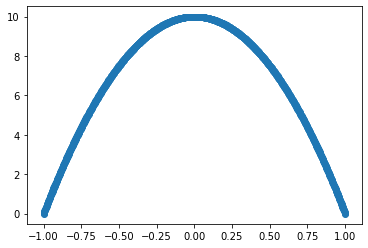

In [228]:
plt.scatter(y, u0)

In [231]:
scipy_optimal_res = root(Gf, u0, jac=jacobian, method='lm')

In [232]:
scipy_optimal_res.success

True

In [233]:
u_star = scipy_optimal_res.x

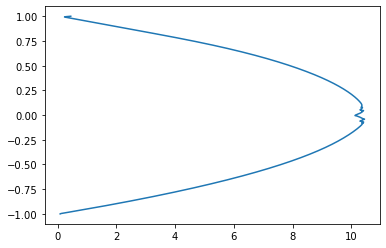

In [234]:
plt.plot(u_star, y)

## Use Numpy gradient + Scipy Root

In [235]:
from scipy.optimize import root, least_squares

In [236]:
ls = np.load('../../data/mixlen_numerical_u180.npy') #previous result

In [237]:
reynolds_stress_fn = lambda y, du_dy: ((k*y)**2) * np.abs(du_dy) * du_dy
diffeq = lambda du2_dy2, dre_dy: hypers['nu']*du2_dy2 + dre_dy - C

In [238]:
# u0 = np.zeros_like(y)

In [239]:
def Gf_np(u):
    u[0],u[-1]=0,0
    du_dy = np.gradient(u, delta_y, edge_order=2)
    dre_dy = np.gradient(reynolds_stress_fn(y, du_dy), delta_y, edge_order=2)
    du2_dy2 = np.gradient(du_dy, delta_y, edge_order=2)
    return diffeq(du2_dy2, dre_dy)

scipy_opt = root(Gf_np, u0, method='lm')

KeyboardInterrupt: 

In [ ]:
scipy_opt.success

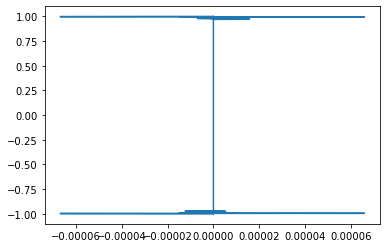

In [56]:
plt.plot(scipy_opt.x, y)
# plt.plot(ls, y, '--');

In [11]:
new_kappa = scipy_opt.x

In [13]:
# np.save('data/mixlen_numerical_u180_halfk.npy', new_kappa)

## retau 1k

In [14]:
hypers['nu']=0.001

In [15]:
scipy_opt1k = root(Gf_np, scipy_opt.x, method='lm')

In [16]:
scipy_opt1k.success

True

In [17]:
prev1k = np.load('data/mixlen_numerical_u1000.npy')

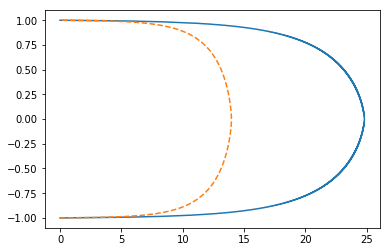

In [18]:
plt.plot(scipy_opt1k.x, y)
plt.plot(prev1k, y, '--');

In [19]:
# np.save('data/mixlen_numerical_u1000_halfk.npy', scipy_opt1k.x)

## Retau 550

In [20]:
hypers['nu']=0.001818181818

In [21]:
scipy_opt550 = root(Gf_np, scipy_opt.x, method='lm')

In [22]:
scipy_opt550.success

True

In [23]:
prev550 = np.load('data/mixlen_numerical_u550.npy')

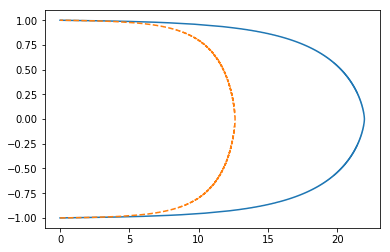

In [24]:
plt.plot(scipy_opt550.x, y)
plt.plot(prev550, y, '--');

In [25]:
# np.save('data/mixlen_numerical_u550_halfk.npy', scipy_opt550.x)

Text(0,0.5,'y')

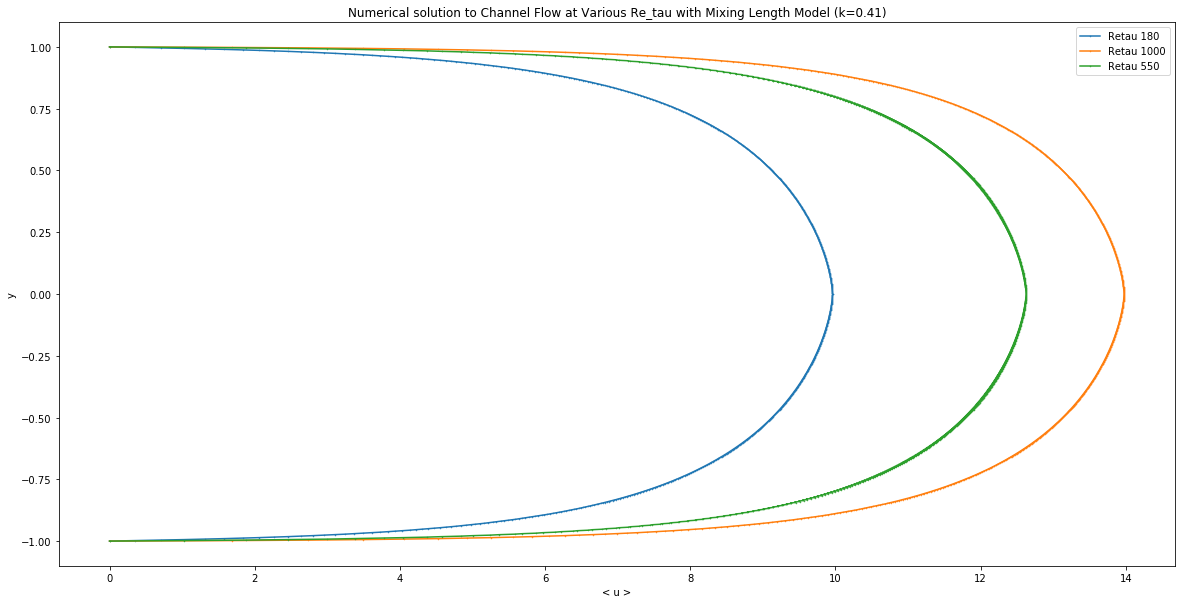

In [15]:
plt.figure(figsize=(20,10))
plt.plot(ls, y, '-o', label='Retau 180', markersize=0.5)
plt.plot(prev1k, y, '-o', label='Retau 1000', markersize=0.5)
plt.plot(prev550, y, '-o', label='Retau 550', markersize=0.5)
plt.legend()
plt.title('Numerical solution to Channel Flow at Various Re_tau with Mixing Length Model (k=0.41)')
plt.xlabel('< u >')
plt.ylabel('y')